In [1]:
library("AnnotationDbi")
library("org.Hs.eg.db")
library(RUVSeq)
source("downstreamAnalysis_RNAseqFunctions.R")

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The f

In [2]:
# Read in data
cts = as.matrix(read.csv("../../data/cts_c.csv", sep=',', row.names='gene'))
coldata = read.csv('../../data/coldata_c.csv', sep=',', row.names='Sample_ID')

cts = cts[,-which(colnames(cts) == 'PB17_236_257_A1')]
coldata = coldata[-which(rownames(coldata) == 'PB17_236_257_A1'),]
cts = cts[,-which(colnames(cts) == 'PB600052_A7')]
coldata = coldata[-which(rownames(coldata) == 'PB600052_A7'),]
cts = cts[,-which(colnames(cts) == 'PB600298_A8')]
coldata = coldata[-which(rownames(coldata) == 'PB600298_A8'),]

dim(coldata)
dim(cts)


[1] 41 15

[1] 61114    41

In [3]:
head(coldata)

,recur,subject_id_per_gc,disease,sex,ethnicity,race,smoking,age,months_surg_postop_colonoscopy,subject_id,TIN,PC1,tissue,block_location,inflammation_status
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
PB12_770_A1,Non-recurrent,12-770,CD,F,NH,WC,0,47,6,12_770,76.2,-24.46333,colon,colon,NI
PB138_A8,Recurrent,138,CD,F,NH,WC,0,22,6,138,80.4,-30.36808,colon,colon,NI
PB140_COLON,Recurrent,140 (604606),CD,M,NH,BAA,0,22,4,140,79.3,-28.24646,colon,,
PB146_A2,Recurrent,604935 (146) (17-0236-382),CD,F,NH,Refused,0,21,9,146,76.8,-25.71356,colon,colon,NI
PB17_236_122_A5,Recurrent,(Hans' bx study) 17-0236-122 SHARE - 600045,CD,M,NH,WC,0,32,6,17_236_122,75.7,-27.38536,colon,colon,NI
PB17_236_177_A6,Non-recurrent,17-0236-177,CD,F,NH,WC,0,18,6,17_236_177,81.5,-21.39823,colon,colon,NI


In [4]:
factor_cols = c('sex', 'recur', 'inflammation_status')
for (col in factor_cols) {
  coldata[,col] = as.factor(coldata[,col])
}
sex = coldata$sex
source = coldata$source
# tissue = coldata$tissue
recur = coldata$recur
inflammation_status = coldata$inflammation_status
tin = coldata$TIN

sample = rownames(coldata)

#round counts to integers
cts <- round(cts);

#check if row names of coldata match colnames of cts
all(rownames(coldata) == colnames(cts))

#adjust for batch and sexBin
design <- as.formula(~ recur)
#create the dds object
dds = DESeqDataSetFromMatrix(countData = cts, colData = coldata, design = design)

vsd = vst(dds)
mat = assay(vsd)
#PCA of raw data
pcaData <- plotPCA(vsd, intgroup=c("recur"), ntop = 500, returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))


[1] TRUE

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [5]:

# #save the plot
# png("results/i/pca_source_raw.png", width=1024, height=512)
# ggplot(pcaData, aes(PC1, PC2, color=source, shape=recur)) +
#     geom_point(size=5) +
#     #geom_text(aes(label=sample),hjust=0, vjust=0) +
#     xlab(paste0("PC1: ",percentVar[1],"% variance")) +
#     ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
#     coord_fixed() +
    
#     theme(text = element_text(size = 24))
# dev.off()

In [6]:
library('GenomicFeatures')
#use the GenomicFeatures package to create a transcript database (txDb) file from our GENCODE annotation file, and use it to pull out the chromosomal coordinates for each of our transcripts (including which chromosome it is on)
txdb = makeTxDbFromGFF('../../data/gencode.v39.annotation.gtf', dbxrefTag = "gene_id", organism = 'Homo sapiens')
k <- keys(txdb, keytype = 'TXNAME')
tx2gene <- AnnotationDbi::select(txdb, keys=k, columns=c('GENEID', 'TXCHROM', 'TXSTART', 'TXEND', 'TXSTRAND'), keytype='TXNAME')
# make a subset of the list containing only the Ensembl gene IDs and the names of the chromosomes, and create a subset for all the genes on chromosomes X and Y
tx2gene_short = tx2gene[,2:3]
tx2gene_short = unique(tx2gene_short)
tx2gene_short_xychrom = tx2gene_short[tx2gene_short$TXCHROM=="chrX" | tx2gene_short$TXCHROM=="chrY",]

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK

'select()' returned 1:1 mapping between keys and columns



In [7]:
#now remove the rows from cts if they are present in 'GENEID' in tx2gene_short_xychrom
cts <- cts[! match(rownames(cts), tx2gene_short_xychrom$GENEID, nomatch=0),]
dim(cts)

[1] 58219    41

In [8]:
#DESeq on the raw data to identify control genes
#filter genes for low expression with edgeR
y <- DGEList(counts=counts(dds), group=recur)
keep <- filterByExpr(y)
table(keep)
y <- y[keep,]
dds <- dds[keep,]

dds <- DESeq(dds)
res <- results(dds)

keep
FALSE  TRUE 
29854 31260 

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This 

In [9]:
table(res$pvalue < 0.5)


FALSE  TRUE 
14354 16906 

In [10]:
set <- newSeqExpressionSet(counts(dds))
set <- betweenLaneNormalization(set, which='upper')
not_sig <- rownames(res)[which(res$pvalue > 0.5)]
empirical <- rownames(set)[ rownames(set) %in% not_sig ]
set <- RUVg(set, empirical, k=20)
pdat <- pData(set)
pdat$recur <- recur
pdat$sex <- sex
pdat$inf <- inflammation_status
pdat$TIN <- tin
pdat$source <- source

In [11]:
#write out the ruv factors to csv
write.csv(pdat, file = "../../results/recur/c/ruvg_runs/data_ruvg.csv")

In [12]:
formula_list = list(
~ sex + W_1 + recur, 
~ sex + W_1 + W_2 + recur, 
~ sex + W_1 + W_2 + W_3 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + recur, 
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + W_19 + recur,
~ sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + W_10 + W_11 + W_12 + W_13 + W_14 + + W_15 + W_16 + W_17 + W_18 + W_19 + W_20 + recur)


In [13]:


#create an empty dataframe to store the number of significant genes
deg_counts = data.frame(matrix(ncol=20, nrow=0))
colnames(deg_counts) = c("formula", "sig_genes")

for (x in seq_along(formula_list)) {
    design_formula = formula(formula_list[[x]])
    dds1 <- DESeqDataSetFromMatrix(countData=cts, colData=pdat, design = design_formula)
    y <- DGEList(counts=counts(dds1), group=coldata$recur)
    keep <- filterByExpr(y)
    table(keep)
    y <- y[keep,]
    dds1 <- dds1[keep,]
    dds1 <- DESeq(dds1)
    res <- results(dds1)
    res <- res[order(res$padj),]
    #get the number of significant genes
    sig_genes <- res[which(res$padj < 0.05),]
    #save the number of significant genes to the dataframe
    deg_counts = rbind(deg_counts, c(x, nrow(sig_genes)))
    #save the results to a csv file
    write.csv(res, paste0("../../results/recur/c/ruvg_runs/res5_", x, ".csv"))
    
}

head(deg_counts, 10)

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R.

In [ ]:
tail(deg_counts, 10)

,formula,sig_genes
,<int>,<int>
11,11,283
12,12,318
13,13,416
14,14,404
15,15,519
16,16,626
17,17,700
18,18,744
19,19,813


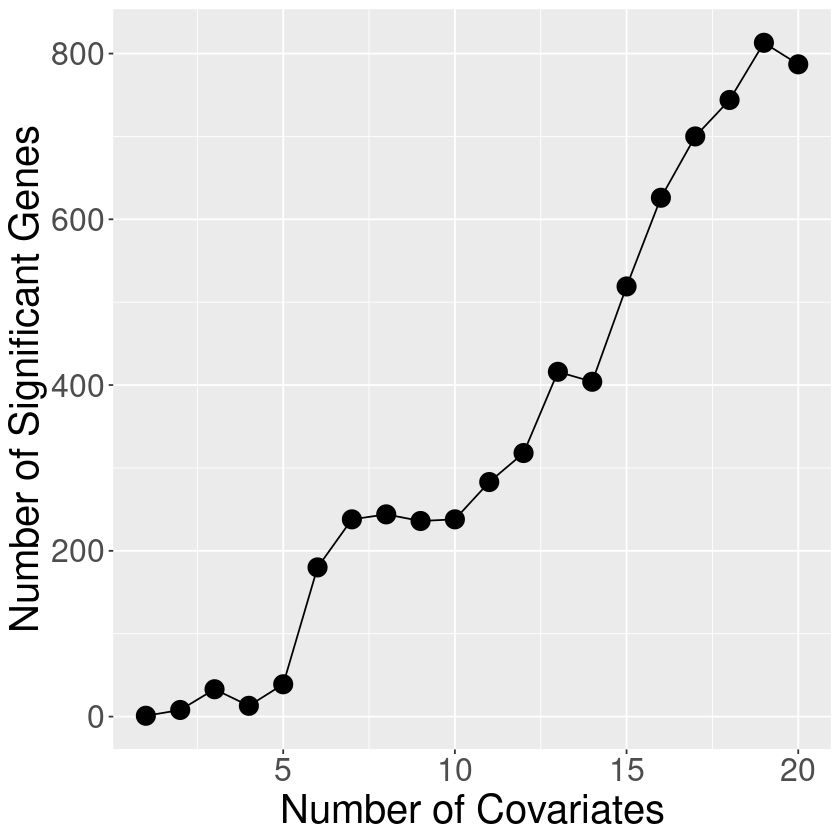

In [ ]:
colnames(deg_counts) = c("formula", "sig_genes")
#plot the number of significant genes vs the number of covariates
ggplot(deg_counts, aes(x=formula, y=sig_genes)) +
    geom_point(size=5) +
    geom_line() +
    xlab("Number of Covariates") +
    ylab("Number of Significant Genes") +
    theme(text = element_text(size = 24))

In [13]:
#use 18 covariates
design_formula = formula(formula_list[[19]])
design_formula

~sex + W_1 + W_2 + W_3 + W_4 + W_5 + W_6 + W_7 + W_8 + W_9 + 
    W_10 + W_11 + W_12 + W_13 + W_14 + +W_15 + W_16 + W_17 + 
    W_18 + W_19 + recur

In [14]:
dds = DESeqDataSetFromMatrix(countData=cts, colData=pdat, design = design_formula)
#filter genes for low expression with edgeR
y <- DGEList(counts=counts(dds), group=recur)
keep <- filterByExpr(y)
table(keep)
y <- y[keep,]
dds <- dds[keep,]
#run DESeq
dds <- DESeq(dds)
res <- results(dds)

converting counts to integer mode

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



keep
FALSE  TRUE 
27975 30244 

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This 

In [15]:
library('pheatmap')
library('genefilter')
#use RemoveBatchEffect to adjust for the identified covariates
#first create variables for each of the RUV factors
ruv1 = pdat$W_1
ruv2 = pdat$W_2
ruv3 = pdat$W_3
ruv4 = pdat$W_4
ruv5 = pdat$W_5
ruv6 = pdat$W_6
ruv7 = pdat$W_7
ruv8 = pdat$W_8
ruv9 = pdat$W_9
ruv10 = pdat$W_10
ruv11 = pdat$W_11
ruv12 = pdat$W_12
ruv13 = pdat$W_13
ruv14 = pdat$W_14
ruv15 = pdat$W_15
ruv16 = pdat$W_16
ruv17 = pdat$W_17
ruv18 = pdat$W_18
ruv19 = pdat$W_19

#run RemoveBatchEffect using the RUV factors and sex
vsd = vst(dds)
mat= assay(vsd)
assay(vsd) <- removeBatchEffect(assay(vsd), batch=sex, covariates=cbind(ruv1, ruv2, ruv3, ruv4, ruv5, ruv6, ruv7, ruv8, ruv9, ruv10, ruv11, ruv12, ruv13, ruv14, ruv15, ruv16, ruv17, ruv18, ruv19))


Attaching package: ‘genefilter’


The following object is masked _by_ ‘.GlobalEnv’:

    varFilter


The following object is masked from ‘package:readr’:

    spec


The following objects are masked from ‘package:MatrixGenerics’:

    rowSds, rowVars


The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars




In [17]:
#plot a PCA of the adjusted data
pcaData <- plotPCA(vsd, intgroup=c("recur"), ntop = 500, returnData=TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))

#save the plot
png("results/c/pca_ruvg_corrected.png", width=1024, height=1024)
ggplot(pcaData, aes(PC1, PC2, color=inflammation_status, shape=recur)) +
    geom_point(size=5) +
    #geom_text(aes(label=sample),hjust=0, vjust=0) +
    xlab(paste0("PC1: ",percentVar[1],"% variance")) +
    ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
    coord_fixed() +
    
    theme(text = element_text(size = 24))
dev.off()

png 
  2

In [21]:
resOrdered <- res[order(res$padj),]
resOrdered$gene <- rownames(resOrdered)
resOrdered = resOrdered[,c(7, 1, 2, 3, 4, 5, 6)]
head(resOrdered)

log2 fold change (MLE): recur Recurrent vs Non.recurrent 
Wald test p-value: recur Recurrent vs Non.recurrent 
DataFrame with 6 rows and 7 columns
                                 gene  baseMean log2FoldChange     lfcSE
                          <character> <numeric>      <numeric> <numeric>
ENSG00000149781.13 ENSG00000149781.13  748.2077       0.402831 0.0550133
ENSG00000283537.2   ENSG00000283537.2   53.6663      11.216101 1.6699201
ENSG00000026751.17 ENSG00000026751.17 1805.7035       0.494217 0.0860967
ENSG00000122188.13 ENSG00000122188.13  899.5152       0.398828 0.0694072
ENSG00000136143.16 ENSG00000136143.16  746.5610      -0.253959 0.0438884
ENSG00000187664.9   ENSG00000187664.9  124.4072      -4.925317 0.8708563
                        stat      pvalue        padj
                   <numeric>   <numeric>   <numeric>
ENSG00000149781.13   7.32243 2.43513e-13 7.07918e-09
ENSG00000283537.2    6.71655 1.86078e-11 2.70474e-07
ENSG00000026751.17   5.74026 9.45338e-09 5.49638e-05
ENSG

In [22]:
#make a list of the top 15 genes
top15 <- resOrdered[1:15,]
recur <- data.frame(recur=coldata$recur)
rownames(recur) <- colnames(mat)
mat15 <- mat[top15$gene,]
#center the data
mat15 <- mat15 - rowMeans(mat15)

In [23]:
#rename the rownames of mat with gene symbols
library("AnnotationDbi")
library("org.Hs.eg.db")

#remove the ENSEMBL version number
rownames(mat15) <- gsub("\\..*", "", rownames(mat15))
rownames(mat15) <- mapIds(org.Hs.eg.db, keys=rownames(mat15), column="SYMBOL", keytype="ENSEMBL", multiVals="first")
head(mat15)

'select()' returned 1:1 mapping between keys and columns



,PB12_770_A1,PB138_A8,PB140_COLON,PB146_A2,PB17_236_122_A5,PB17_236_177_A6,PB17_236_292_B2,PB17_236_387_A10,PB17_236_398_A2,PB17_236_520_A2,⋯,PB600444_A2,PB601102_A3,PB601990_A8,PB602717_A9,PB603387_A2,PB603967_A7,PB604520_A3,PB605312_A5,PB75_A10,PBCHAMP7_A12
FERMT3,-0.7510937,0.3249750,0.3277472,0.3821316,-0.62266378,-0.2517798,0.2314318,-0.4673792,-0.51300306,0.16861463,⋯,-0.01658237,-0.3668822,-0.2437442,-0.1456490,-0.02950445,0.2709670,-0.422292903,-0.7089087,-0.5738292,0.5743894
NA,-1.0111410,-1.0111410,1.4590577,-1.0111410,-1.01114102,-1.0111410,-1.0111410,1.0562515,-1.01114102,-1.01114102,⋯,1.14711129,1.1604861,1.2882035,1.2433581,-1.01114102,-1.0111410,0.819564235,-0.5062618,-1.0111410,-1.0111410
SLAMF7,-1.5319203,0.4619804,0.6576220,0.1394215,-0.07947141,-0.7006812,0.5012091,-0.6652370,-0.84395437,-0.63449251,⋯,0.02523538,-0.6620506,-0.6479114,-1.0108806,-0.51213335,1.1175265,0.006795738,-0.7720085,-0.8488824,0.4339631
LAX1,-0.7384398,0.1949079,0.7841796,0.2600180,-0.58402782,-0.5547324,-0.1605173,-0.6875512,-0.69550777,-0.38477126,⋯,-0.25998249,-0.1684362,-0.6411026,-0.5767867,-0.13229522,1.0361546,-0.221319885,-0.7557723,-0.5795373,0.5443262
SUCLA2,0.2027654,-0.1768142,-0.4738033,-0.2167849,0.09179106,0.3543726,0.2749289,0.4106331,-0.09847058,0.06509136,⋯,0.01240000,-0.4122660,0.2877900,0.1509653,-0.06936091,-0.3355511,-0.162408832,0.2202813,-0.2045929,-0.4229938
HAPLN4,1.5516064,-1.9812658,-1.9812658,-1.9812658,-1.98126582,0.5855538,0.4066118,-1.9812658,1.29276046,0.87676949,⋯,-0.54964236,1.9007916,-1.9812658,1.0444594,-1.98126582,0.4971795,-1.981265819,-1.9812658,-1.9812658,0.6304947


In [24]:
#sort each dataframe by recurrence
#first sort the annotation data by recurrence while keeping it as a dataframe
recur <- recur[order(recur$recur), , drop=FALSE]
#then sort the matrix by the order of the annotation data by getting the rownames of the annotation data and reordering the columns of the matrix
col_order = rownames(recur)
mat15 <- mat15[,col_order]

In [25]:
#remove the sample names from the heatmap
pheatmap(mat15, annotation_col=recur, cluster_cols=F, show_colnames=F, filename='../../results/recur/c/ruvg_runs/heatmap.png', height=10, width=10)